# Covid-19 Analysis

Looking at the Covid-19 data obtained from 'Our World in Data'.

**Index:**

- [Countries with total cases per capita, top 5](#Highest-total-cases-per-capita,-top-5)
- [Countries with highest death rate per cases, top 5](#Highest-death-rate-per-total-cases,-top-5)
- [Comparison of new cases by countries](#Comparison-of-new-cases-by-countries)
  <br>Edit the name of the countries in filter_countries variable or add new ones to plot<br>
- [Comparison of new cases by countries per capita](#Comparison-of-new-cases-by-countries-per-capita)
 <br>Edit the name of the countries in filter_countries variable or add new ones to plotplot<br>

## Extracting coronavirus and country data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests

In [ ]:
r = requests.get('https://covid.ourworldindata.org/data/ecdc/full_data.csv')

In [ ]:
with open('full_data.csv', 'wb') as fd:
    for chunk in r.iter_content(chunk_size = 128):
        fd.write(chunk)

In [178]:
rdata = pd.read_csv('full_data.csv')
rpopulation_data = pd.read_csv('population_data.csv') 

In [179]:
rdata.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0


In [180]:
rpopulation_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0,105366.0,105845.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.0,9169410.0,9351441.0,9543205.0,9744781.0,9956320.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0,36296400.0,37172386.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5454933.0,5531472.0,5608539.0,5679458.0,5735044.0,5770570.0,...,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0,29816748.0,30809762.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0,77001.0,77006.0,NaN


## Filtering and cleaning data 

In [181]:
print("Data Types", rdata.dtypes)
print("Columns with NaN", rdata.columns[rdata.isna().any()])

Data Types date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object
Columns with NaN Index([], dtype='object')


In [182]:
rdata = rdata.fillna(value = 0)
pdata = rdata.astype({'new_cases':'int64', 
                     'new_deaths':'int64', 
                     'total_deaths':'int64'})
pdata.dtypes

date            object
location        object
new_cases        int64
new_deaths       int64
total_cases      int64
total_deaths     int64
dtype: object

In [183]:
rdata['date_fm'] = pd.to_datetime(rdata['date'], infer_datetime_format='%Y-%m-%d')

In [184]:
rdata.dtypes

date                    object
location                object
new_cases                int64
new_deaths               int64
total_cases              int64
total_deaths             int64
date_fm         datetime64[ns]
dtype: object

In [185]:
latest = pdata['date'].max()
latest

'2020-03-25'

In [186]:
world_record = rdata[rdata['location'] == 'World']
data = pdata[pdata['date'] == latest]
data.head()
data = data.drop('date', axis = 1)
data = data.set_index('location')

In [187]:
data = data[data.index != 'World']

In [188]:
max_total_cases = data['total_cases'].max()
print("Max value in total cases", max_total_cases)

Max value in total cases 81847


In [189]:
population = rpopulation_data.filter(['Country Name', '2018'])
population[population['Country Name'] == 'Canada']

,Country Name,2018
33,Canada,37058856.0


In [190]:
population = population.rename(columns = {'Country Name':'location'})
population = population.set_index('location')
population.head(n=1)

,2018
location,
Aruba,105845.0


In [191]:
data[data.index.isin(population.index) == False]

,new_cases,new_deaths,total_cases,total_deaths
location,,,,
Guernsey,3,0,23,0
Jersey,0,0,18,0
Montserrat,0,0,1,0
Netherlands Antilles,5,0,22,0
Palestine,1,0,60,0
Taiwan,21,0,216,2
Vatican,0,0,1,0


In [192]:
data['total_cases_per_capita'] = data['total_cases'].div(data.index.map(population['2018']))
data['total_deaths_per_capita'] = data['total_deaths'].div(data.index.map(population['2018']))
data['deaths_per_total'] = data['total_deaths'].div(data['total_cases'])
data['deaths_per_total'] = data['deaths_per_total'].round(decimals = 4)
data.head()

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Afghanistan,2,0,42,1,1.129871e-06,2.690169e-08,0.0238
Albania,23,1,123,5,4.291133e-05,1.744363e-06,0.0407
Algeria,42,0,231,17,5.470248e-06,4.025724e-07,0.0736
Andorra,31,0,164,0,2.129704e-03,0.000000e+00,0.0000
Angola,0,0,2,0,6.491449e-08,0.000000e+00,0.0000


In [193]:
data.dtypes

new_cases                    int64
new_deaths                   int64
total_cases                  int64
total_deaths                 int64
total_cases_per_capita     float64
total_deaths_per_capita    float64
deaths_per_total           float64
dtype: object

## Plots

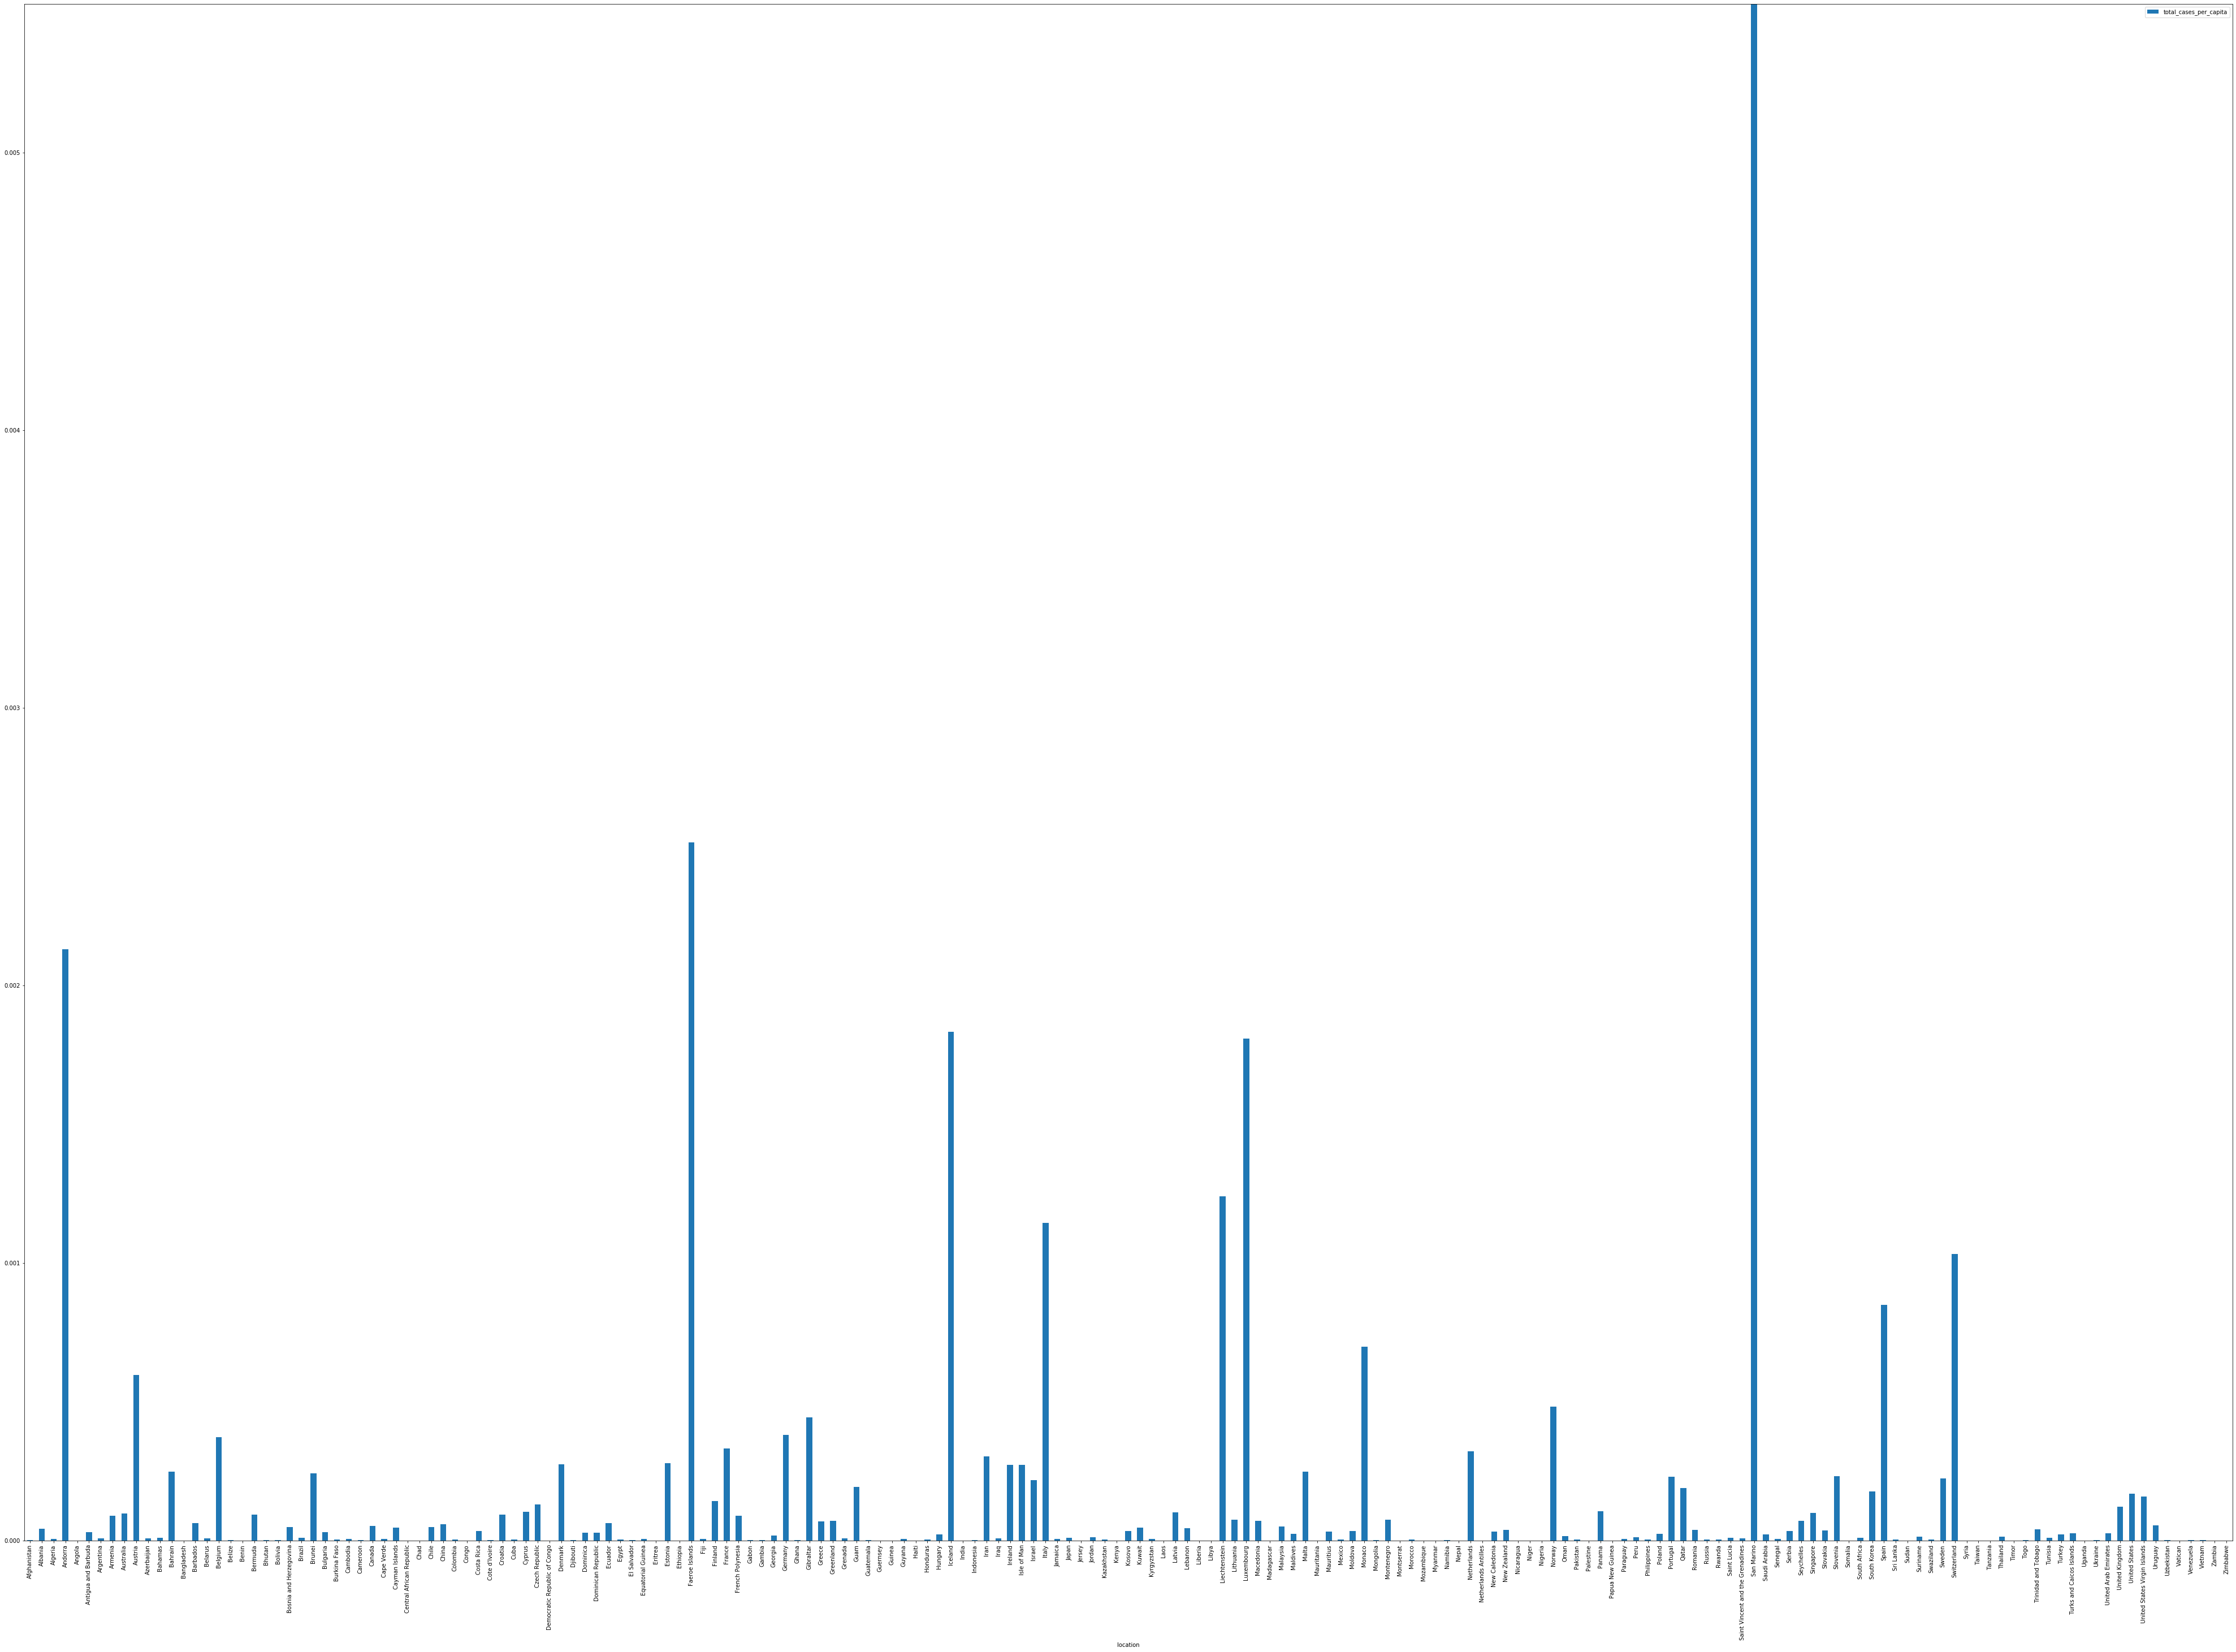

In [194]:
all_rows = data.plot(kind='bar', y = 'total_cases_per_capita', 
                     figsize = (70, 50), ylim = (0, data['total_cases_per_capita'].max())).get_figure()
plt.savefig('all_rows.png')

### World Record

In [195]:
world_record = world_record.drop(columns = ['date'])
world_record = world_record.set_index('date_fm')

In [196]:
world_record[world_record.index == latest]

,location,new_cases,new_deaths,total_cases,total_deaths
date_fm,,,,,
2020-03-25,World,38876,2200,416916,18565


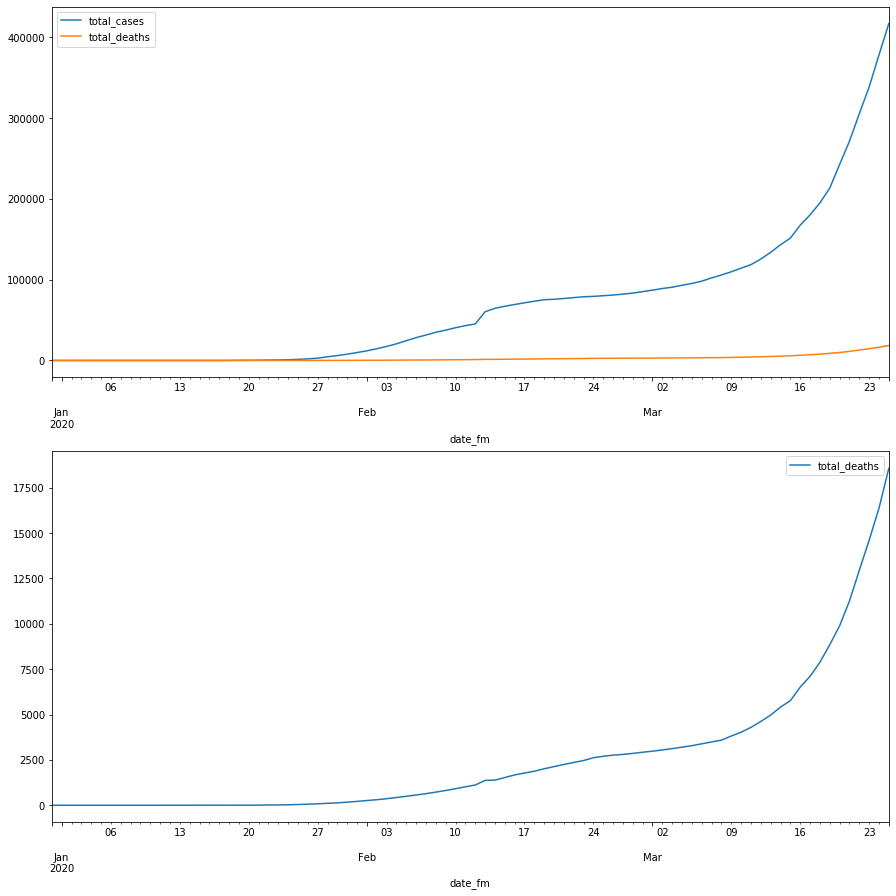

In [197]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))

world_record.plot(kind='line', y= ['total_cases', 'total_deaths'], ax = ax1)
world_record.plot(kind='line', y= 'total_deaths', ax = ax2)


### Highest total cases per capita, top 5

In [198]:
largest5 = data.nlargest(5, 'total_cases_per_capita')
largest5

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
San Marino,0,1,187,21,0.005535,0.000622,0.1123
Faeroe Islands,4,0,122,0,0.002516,0.000000,0.0000
Andorra,31,0,164,0,0.002130,0.000000,0.0000
Iceland,60,0,648,2,0.001833,0.000006,0.0031
Luxembourg,224,0,1099,8,0.001808,0.000013,0.0073


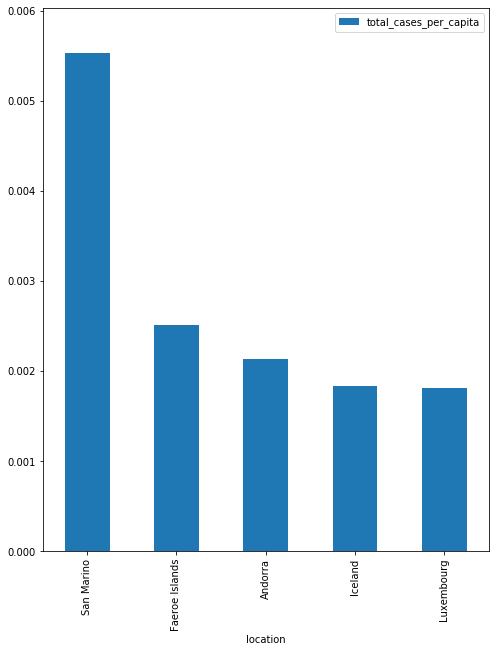

In [199]:
total_cases_pc_fig = largest5.plot(kind='bar', 
                                   y = 'total_cases_per_capita', 
                                   ylim = (0, data['total_cases_per_capita'].max()+ 0.0005),
                                   figsize = (8, 10)).get_figure()
plt.savefig('total_cases_per_capita.png')

In [200]:
largest5 = largest5.merge(population, on = 'location')

In [201]:
filtered_for_table = largest5.drop(columns = ['total_deaths_per_capita', 'deaths_per_total', 'new_deaths', 'total_deaths'])
filtered_for_table = filtered_for_table.reset_index()
filtered_for_table = filtered_for_table.rename(columns = {'2018':'population'})
filtered_for_table

,location,new_cases,total_cases,total_cases_per_capita,population
0,San Marino,0,187,0.005535,33785.0
1,Faeroe Islands,4,122,0.002516,48497.0
2,Andorra,31,164,0.002130,77006.0
3,Iceland,60,648,0.001833,353574.0
4,Luxembourg,224,1099,0.001808,607728.0


### Highest death rate per total cases, top 5

In [202]:
deaths_per_cases = data[data['total_cases'] > 50].nlargest(5, 'deaths_per_total')
deaths_per_cases

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
San Marino,0,1,187,21,0.005535,6.215776e-04,0.1123
Italy,5249,743,69176,6820,0.001145,1.128555e-04,0.0986
Iraq,50,4,316,27,0.000008,7.025103e-07,0.0854
Indonesia,107,6,686,55,0.000003,2.054819e-07,0.0802
Iran,1762,122,24811,1934,0.000303,2.364295e-05,0.0779


In [203]:
deaths_per_cases['deaths_per_total']

location
San Marino    0.1123
Italy         0.0986
Iraq          0.0854
Indonesia     0.0802
Iran          0.0779
Name: deaths_per_total, dtype: float64

In [204]:
deaths_per_cases_pop = deaths_per_cases.merge(population, on = 'location')

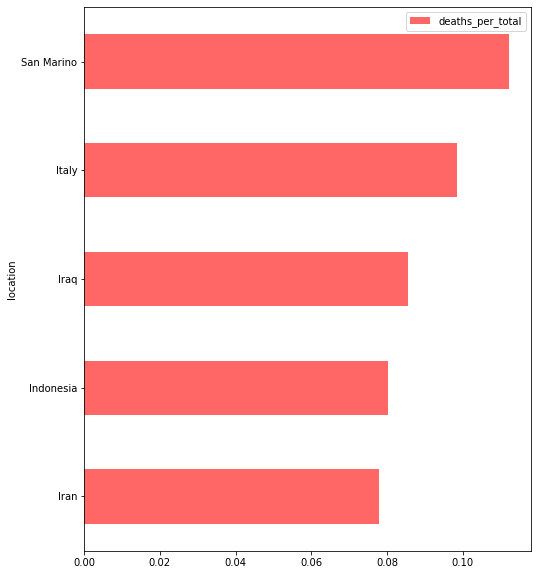

In [205]:
deaths_per_cases_pop.sort_values(by = 'deaths_per_total', ascending = True, inplace = True)
deaths_per_cases_fig = deaths_per_cases_pop.plot.barh(y = 'deaths_per_total', 
                                                      color ='red',
                                                      figsize = (8, 10),
                                                      alpha = 0.6).get_figure()
plt.savefig('deaths_per_cases.png')

In [206]:
filtered_for_table = deaths_per_cases_pop.drop(columns = ['new_cases', 'new_deaths', 'total_cases_per_capita', 'total_deaths_per_capita'])
filtered_for_table = filtered_for_table.reset_index()
filtered_for_table = filtered_for_table.rename(columns = {'2018':'population'})
filtered_for_table

,location,total_cases,total_deaths,deaths_per_total,population
0,Iran,24811,1934,0.0779,81800269.0
1,Indonesia,686,55,0.0802,267663435.0
2,Iraq,316,27,0.0854,38433600.0
3,Italy,69176,6820,0.0986,60431283.0
4,San Marino,187,21,0.1123,33785.0


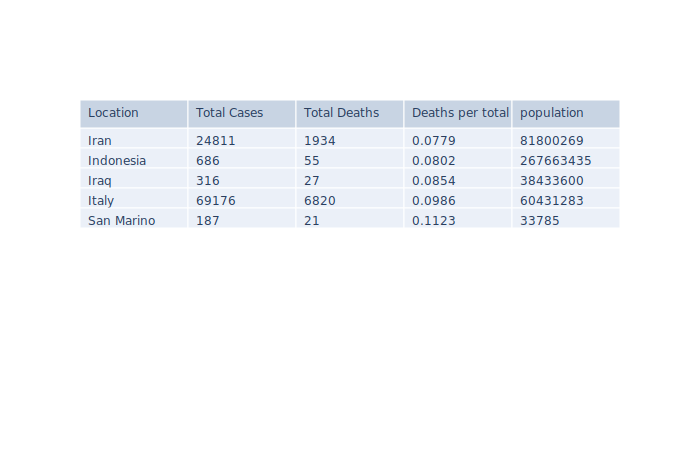

In [207]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Location', 
                        'Total Cases', 
                        'Total Deaths',
                        'Deaths per total', 
                        'population'],
                align='left'),
    cells=dict(values=[filtered_for_table['location'], 
                       filtered_for_table['total_cases'], 
                       filtered_for_table['total_deaths'], 
                       filtered_for_table['deaths_per_total'],
                       filtered_for_table['population']
                      ],
               align='left'))
])

fig.show(renderer="svg")

### Comparison of new cases by countries

In [208]:
filter_countries = ['Canada','United States', 'Pakistan']

In [209]:
data[data.index.isin(filter_countries)]

,new_cases,new_deaths,total_cases,total_deaths,total_cases_per_capita,total_deaths_per_capita,deaths_per_total
location,,,,,,,
Canada,313,3,1959,27,0.000053,7.285708e-07,0.0138
Pakistan,104,1,991,7,0.000005,3.298541e-08,0.0071
United States,8789,211,55231,801,0.000169,2.448288e-06,0.0145


In [210]:
earliest = '2020-03-01'
country_subset = rdata[rdata['location'].isin(filter_countries) & rdata['date_fm'].between(earliest, latest)]

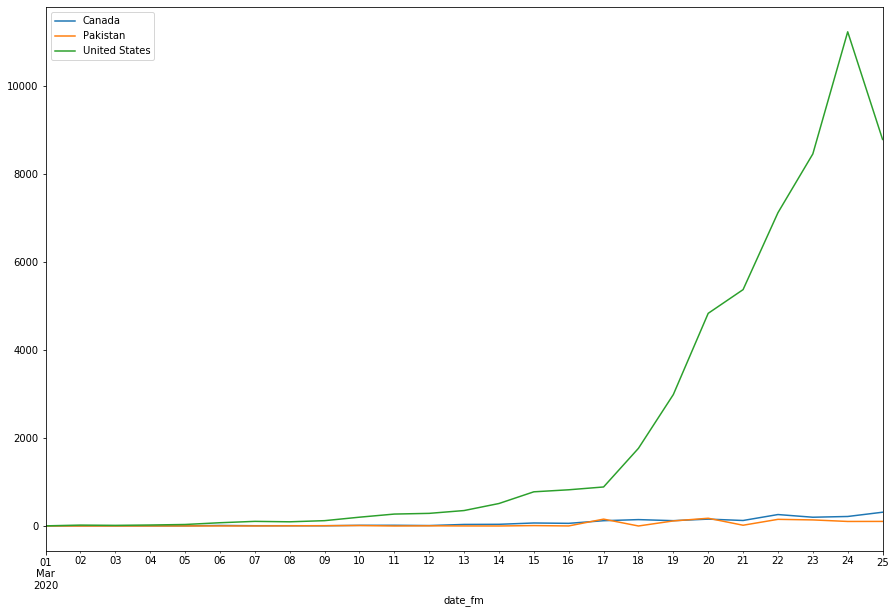

In [211]:
_, ax = plt.subplots(figsize = (15, 10))

for name, group in country_subset.groupby('location'):
    group.set_index('date_fm').plot(kind ='line', y = 'new_cases', ax = ax, label = name)

plt.show()

### Comparison of new cases by countries per capita

In [212]:
percapita = pd.DataFrame(country_subset['location'])
percapita['date_fm'] = country_subset['date_fm']
percapita['new_cases_per_capita'] =  country_subset['new_cases'].div(country_subset['location'].map(population['2018']))

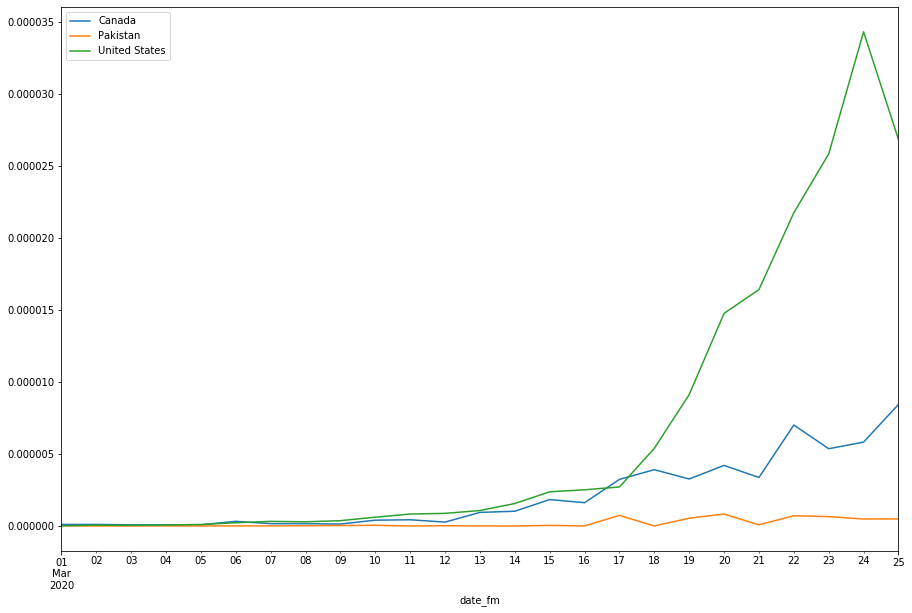

In [213]:
_, ax = plt.subplots(figsize = (15, 10))

for name, group in percapita.groupby('location'):
    group.set_index('date_fm').plot(kind ='line', y = 'new_cases_per_capita', ax = ax, label = name)

plt.show()

In [214]:
new_cases_us = country_subset[country_subset['location'] == 'Canada'].drop(columns = ['date_fm'])
new_cases_us

,date,location,new_cases,new_deaths,total_cases,total_deaths
1152,2020-03-01,Canada,4,0,20,0
1153,2020-03-02,Canada,4,0,24,0
1154,2020-03-03,Canada,3,0,27,0
1155,2020-03-04,Canada,3,0,30,0
1156,2020-03-05,Canada,3,0,33,0
1157,2020-03-06,Canada,12,0,45,0
1158,2020-03-07,Canada,6,0,51,0
1159,2020-03-08,Canada,6,0,57,0
1160,2020-03-09,Canada,5,0,62,0
1161,2020-03-10,Canada,15,1,77,1


## Resources
1. Data obtained from: https://ourworldindata.org/coronavirus-source-data
2. Population data from: https://data.worldbank.org/indicator/SP.POP.TOTL